<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Forecasting-of-cab-orders" data-toc-modified-id="Forecasting-of-cab-orders-1">Forecasting of cab orders</a></span></li><li><span><a href="#Preparation" data-toc-modified-id="Preparation-2">Preparation</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-3">Analysis</a></span><ul class="toc-item"><li><span><a href="#Analysis-of-available-data" data-toc-modified-id="Analysis-of-available-data-3.1">Analysis of available data</a></span></li><li><span><a href="#Preparing-new-features" data-toc-modified-id="Preparing-new-features-3.2">Preparing new features</a></span></li></ul></li><li><span><a href="#Learning" data-toc-modified-id="Learning-4">Learning</a></span><ul class="toc-item"><li><span><a href="#Creating-samples" data-toc-modified-id="Creating-samples-4.1">Creating samples</a></span></li><li><span><a href="#Verification-of-elementary-models" data-toc-modified-id="Verification-of-elementary-models-4.2">Verification of elementary models</a></span></li><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-4.3">Linear Regression</a></span></li><li><span><a href="#Decision-Tree" data-toc-modified-id="Decision-Tree-4.4">Decision Tree</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-4.5">Random Forest</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.6">LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.7">CatBoost</a></span></li><li><span><a href="#Best-Model-Testing" data-toc-modified-id="Best-Model-Testing-4.8">Best Model Testing</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5">Conclusion</a></span></li></ul></div>

# Forecasting of cab orders

This project was done as part of a Data Science course by Yandex Practicum. 

It is a demand forecasting problem on cab orders of a fictitious firm. This task is an example of a <b>Time Series problem</b>, which reduces to a <b>regression problem</b>. To solve the problem, data from about half a year in the past was provided, and the <b>RMSE</b> metric value to be achieved on a test sample was given.

<b>Task description:</b>

"Imaginary Taxi" has collected historical data on cab orders at airports. In order to attract more drivers during the peak period, we need to predict the number of cab orders for the next hour. We need to build a model for this prediction.

The value of the RMSE metric on the test sample should be no greater than 48.

<b>Project Work Plan:</b>
- Loading and resampling data;
- Data analysis;
- Adding additional features before model training begins;
- Application of elementary models (mean, median, prior value, value shifted to the past);
- Application of complex models (Linear Regression, Decision Tree Regressor, Random Forest Regressor, LGBM Regressor, Cat Boost Regressor);
- Choosing the best model based on the best RMSE metric and testing on a test sample;
- Summarizing conclusions.

<b>Author of the project:</b>

Victoria Kuskova

# Preparation

We'll organize all library imports, data file imports, and general data file information into individual cells.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [2]:
#import data
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


We can see that we have successfully loaded the data by creating an index by date. But now we need to perform resampling by one hour.

In [4]:
df.sort_index(inplace=True)
df = df.resample('1H').sum()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


The volume of rows has decreased, which is good, it means that the data is grouped. We can see that we have data from March to August 2018. Let's look at the first rows.

In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Yes, the data is loaded, now let's take a closer look at it and try to analyze it.

# Analysis

## Analysis of available data

We'll look at how the data changes against time.

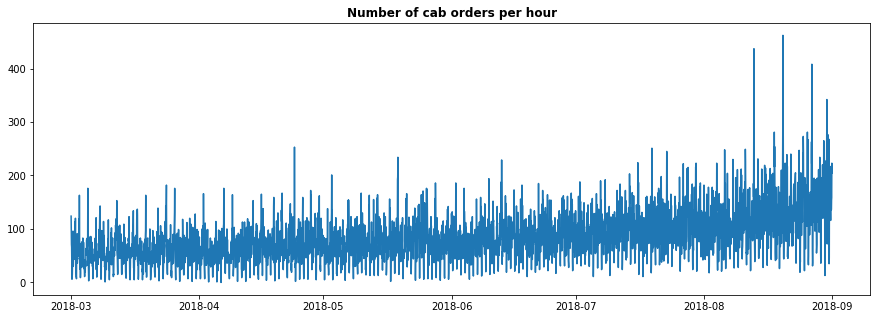

In [7]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(15, 5))
plt.title("Number of cab orders per hour", fontweight='bold', size='large')
plt.plot(df)
plt.show()

Even from this graph we can draw <b>the first conclusions</b>:

- the number of orders gradually increases from March to August.
- The maximum number of orders per 1 hour was in August, we can even see a few outliers.
- The value fluctuates from hour to hour, that's why the graph is so bouncy.

Since we can see that the number of orders on average is gradually increasing. And in August the average is higher than in March. Also, the fluctuations in the data start to be stronger in August. So both the average and the standard deviation change over time. This suggests that our series is <b>non-stationary</b>.

We'll take a closer look at it. We will add a moving average, where the moving average is 24 (analogous to the average number of orders per day). Add this column at once, so that the moving average is calculated without taking into account the current hour.

In [8]:
df['rolling_mean'] = df['num_orders'].shift().rolling(24).mean()

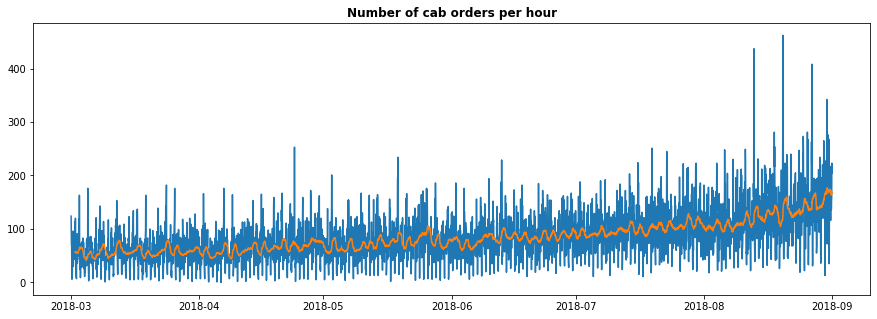

In [9]:
plt.figure(figsize=(15, 5))
plt.title("Number of cab orders per hour", fontweight='bold', size='large')
plt.plot(df)
plt.show()

Yes, we see confirmation of our observations: 
- The average number of orders per hour is clearly increasing - there is a definite <b>trend</b>. 
- But we also see a certain <b>seasonality</b> from day to day. 

Let's take a closer look at these parameters.

In [10]:
decomposed = seasonal_decompose(df['num_orders'])

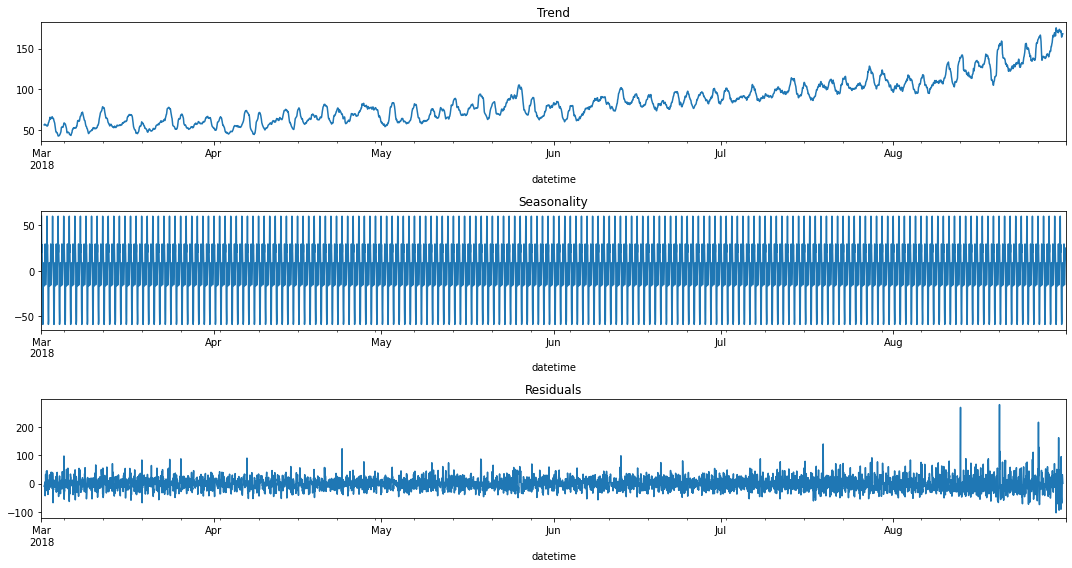

In [11]:
plt.figure(figsize=(15, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

We can see rather dense plots over such a large period of time. But the increasing trend, seasonality and residual component can be seen. 

Let's look at it on a shorter period of time - August.

In [12]:
decomposed2 = seasonal_decompose(df['2018-08':'2018-08']['num_orders'])

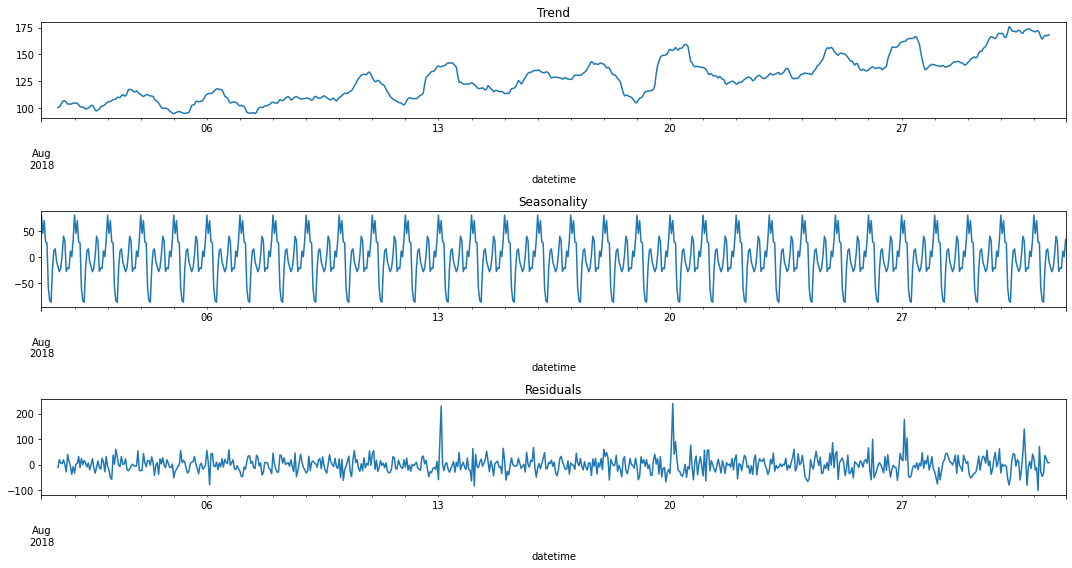

In [13]:
plt.figure(figsize=(15, 8))
plt.subplot(311)
decomposed2.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed2.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed2.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

We can definitely see seasonality, which is very similar to the dependence on the time of day. The number of cyclic peaks and drops is equal to the number of days in August.

## Preparing new features

We will add additional columns to our sample. We will start with time indicators: <b>calendar features</b>.

In [14]:
ml_df = df.copy()

In [15]:
ml_df['year'] = ml_df.index.year
ml_df['month'] = ml_df.index.month
ml_df['day'] = ml_df.index.day
ml_df['dayofweek'] = ml_df.index.dayofweek
ml_df['hour'] = ml_df.index.hour

In [16]:
ml_df.head()

,num_orders,rolling_mean,year,month,day,dayofweek,hour
datetime,,,,,,,
2018-03-01 00:00:00,124,NaN,2018,3,1,3,0
2018-03-01 01:00:00,85,NaN,2018,3,1,3,1
2018-03-01 02:00:00,71,NaN,2018,3,1,3,2
2018-03-01 03:00:00,66,NaN,2018,3,1,3,3
2018-03-01 04:00:00,43,NaN,2018,3,1,3,4


Now we're going to add <b>lag features</b>.

In [17]:
for lag in range(1, 25):
    ml_df['lag_{}'.format(lag)] = ml_df['num_orders'].shift(lag)

In [18]:
ml_df.head()

,num_orders,rolling_mean,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,2018,3,1,3,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,2018,3,1,3,1,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,2018,3,1,3,2,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,2018,3,1,3,3,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,2018,3,1,3,4,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Additional features: calendar features and lag features have been added.

# Learning

## Creating samples

We are going to create test and training samples.

In [19]:
train, test = train_test_split(ml_df, shuffle=False, test_size=0.1)
train = train.dropna()

target_train = train['num_orders']
target_test = test['num_orders']
features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)

In [20]:
train.index.min(), train.index.max(), test.index.min(), test.index.max()

(Timestamp('2018-03-02 00:00:00', freq='H'),
 Timestamp('2018-08-13 13:00:00', freq='H'),
 Timestamp('2018-08-13 14:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

In [21]:
target_train.shape, target_test.shape, features_train.shape, features_test.shape

((3950,), (442,), (3950, 30), (442, 30))

Splitting was successful, joint on date of 08/13/2018. The sample sizes are 9 to 1. The only point is that because of the shifting by columns with lagging data - we have deleted some rows for 01.03, as they were with empty values due to the peculiarities of the calculation.

## Verification of elementary models

Let's see what happens if you predict with a constant: median and mean.

In [22]:
pred_median = np.ones(target_test.shape)*target_train.median()
pred_mean = np.ones(target_test.shape)*target_train.mean()

In [23]:
mean_squared_error(target_test, pred_median)**0.5, mean_squared_error(target_test, pred_mean)**0.5

(87.15277582981295, 84.6499381993622)

Now look at the RMSE of the model - the prediction by the previous value of the series.

In [24]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

In [25]:
mean_squared_error(target_test, pred_previous)**0.5

58.856486242815066

Note this value, and because we remember that there is seasonality at 24 hours, let's look at the 24 hour shift model.

In [26]:
pred_previous_24 = features_test['lag_24']

In [27]:
mean_squared_error(target_test, pred_previous_24)**0.5

57.187059099999075

A little better, note this value as well. And let's proceed to more complex models.

| N |       Model                | RMSE on a test sample |  
|---|----------------------------|------------|
| 1 | Median |   87.15  |  
| 2 | Mean |   84.64 | 
| 3 | Previous |   58.85 | 
| 4 | Previous 24 |   57.18 |  

## Linear Regression

We will look at the linear regression model first. We will use <b>TimeSeriesSplit</b> for the correct operation of crossvalidation.

In [28]:
%%time
warnings.filterwarnings('ignore')
model_lin_reg = LinearRegression()

scores_lin_reg = cross_val_score(
    model_lin_reg, features_train, target_train,
    cv=TimeSeriesSplit(n_splits=5).split(features_train), scoring = 'neg_mean_squared_error')

rmse_lin_reg = sum((-1*scores_lin_reg)**0.5)/5
rmse_lin_reg 

CPU times: user 166 ms, sys: 283 ms, total: 449 ms
Wall time: 405 ms


26.9414643728525

Great, the necessary metric has been achieved in training! Perhaps everything will change on the testing, but for now we will remember this result and move on to other models.

More complex models will be saved in a new table.

| N |       Model                | RMSE |  
|---|----------------------------|------------|
| 1 |LinearRegression |   26.94 |  


## Decision Tree

We are going to tune the hyperparameters using a cycle. Because with cross-validation there is a risk of mixing samples, which we don't need

In [29]:
model_decision_tree = DecisionTreeRegressor(random_state=12345)
parameters_decision_tree = { 'max_depth': range(1, 20) }

In [30]:
%%time
grid_search = GridSearchCV(
    estimator = model_decision_tree, param_grid = parameters_decision_tree,
    scoring = 'neg_mean_squared_error', n_jobs = -1,
    cv=TimeSeriesSplit(n_splits=5).split(features_train)
)
grid_search.fit(features_train, target_train)

CPU times: user 2.78 s, sys: 8.66 ms, total: 2.79 s
Wall time: 2.8 s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f75da8662e0>,
             estimator=DecisionTreeRegressor(random_state=12345), n_jobs=-1,
             param_grid={'max_depth': range(1, 20)},
             scoring='neg_mean_squared_error')

In [31]:
grid_search.best_params_ , (-1*grid_search.best_score_)**0.5

({'max_depth': 5}, 30.65943897815898)

Decision tree seems to solve this problem worse than linear regression.

| N |       Model                | RMSE |  
|---|----------------------------|------------|
| 1 |LinearRegression |   26.94 |   
| 2 | DecisionTreeRegressor |   30.65 |  

## Random Forest

We are going to tune the hyperparameters using a cycle as well.

In [32]:
model_random_forest = RandomForestRegressor(random_state=12345)
parameters_random_forest = { 'n_estimators': range(1, 21),
                            'max_depth': range(1, 11) }

In [33]:
%%time
grid_search = GridSearchCV(
    estimator = model_random_forest, param_grid = parameters_random_forest,
    scoring = 'neg_mean_squared_error', n_jobs = -1,
    cv=TimeSeriesSplit(n_splits=5).split(features_train)
)
grid_search.fit(features_train, target_train)

CPU times: user 1min 56s, sys: 305 ms, total: 1min 56s
Wall time: 1min 57s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f75da8669e0>,
             estimator=RandomForestRegressor(random_state=12345), n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'n_estimators': range(1, 21)},
             scoring='neg_mean_squared_error')

In [34]:
grid_search.best_params_ , (-1*grid_search.best_score_)**0.5

({'max_depth': 9, 'n_estimators': 20}, 26.312690595685734)

That's a great metric! Let's record it.

| N |       Model                | RMSE |  
|---|----------------------------|------------|
| 1 |LinearRegression |   26.94 |   
| 2 | DecisionTreeRegressor |   30.65 |  
| 3 | RandomForestRegressor |   26.31 | 

## LightGBM

We will try to solve this regression problem through the LightGBM library.

In [35]:
model_lgbm = LGBMRegressor(random_state=12345)

parameters = { 'n_estimators': [10, 20, 30],
              'max_depth': [5, 10, 20],
             'learning_rate': [0.1, 1.0]
             }

In [36]:
%%time
grid_search = GridSearchCV(
    estimator = model_lgbm, param_grid = parameters,
    scoring = 'neg_mean_squared_error', n_jobs = -1,
    cv=TimeSeriesSplit(n_splits=5).split(features_train)
)

grid_search.fit(features_train, target_train)

CPU times: user 35.6 s, sys: 360 ms, total: 35.9 s
Wall time: 36.2 s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f75e7772660>,
             estimator=LGBMRegressor(random_state=12345), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 1.0], 'max_depth': [5, 10, 20],
                         'n_estimators': [10, 20, 30]},
             scoring='neg_mean_squared_error')

In [37]:
grid_search.best_params_ , (-1*grid_search.best_score_)**0.5

({'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 30},
 25.671204463244713)

This metric is even better.

| N |       Model                | RMSE |  
|---|----------------------------|------------|
| 1 |LinearRegression |   26.94 |   
| 2 | DecisionTreeRegressor |   30.65 |  
| 3 | RandomForestRegressor |   26.31 | 
| 4 | LGBMRegressor |   25.67 |

## CatBoost

Now we proceed to regression from CatBoost.

Unfortunately, the kernel did not allow us to tune any hyperparameters in this model, so here we stop on the basic one, without searching parameters

In [38]:
model_cat_boost = CatBoostRegressor(random_seed=12345,
                                    loss_function='RMSE')

#parameters_cat_boost = { 'n_estimators': [20, 50]}

In [39]:
%%time
grid_search = GridSearchCV(
    estimator = model_cat_boost, scoring ='neg_mean_squared_error', 
    param_grid = {}, n_jobs = -1,
    cv=TimeSeriesSplit(n_splits=5).split(features_train)
)

grid_search.fit(features_train, target_train, verbose=1000)

Learning rate set to 0.038341
0:	learn: 29.1727525	total: 51.1ms	remaining: 51s
999:	learn: 2.6326690	total: 3.06s	remaining: 0us
Learning rate set to 0.042769
0:	learn: 29.7707315	total: 5.01ms	remaining: 5s
999:	learn: 5.2655049	total: 3.54s	remaining: 0us
Learning rate set to 0.045595
0:	learn: 31.3866665	total: 7.71ms	remaining: 7.71s
999:	learn: 6.9767456	total: 4.06s	remaining: 0us
Learning rate set to 0.047713
0:	learn: 32.7069004	total: 6.14ms	remaining: 6.14s
999:	learn: 8.1339254	total: 4.4s	remaining: 0us
Learning rate set to 0.049424
0:	learn: 33.9938837	total: 6.68ms	remaining: 6.67s
999:	learn: 9.3887205	total: 4.74s	remaining: 0us
Learning rate set to 0.050868
0:	learn: 37.7422838	total: 6.76ms	remaining: 6.76s
999:	learn: 10.8212486	total: 5.45s	remaining: 0us
CPU times: user 25.3 s, sys: 673 ms, total: 26 s
Wall time: 30.7 s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f75e7772270>,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f75dac954f0>,
             n_jobs=-1, param_grid={}, scoring='neg_mean_squared_error')

In [40]:
(-1*grid_search.best_score_)**0.5

24.52736175285868

CatBoostRegressor model has shown better results than LGBMRegressor.

| N |       Model                | RMSE |  
|---|----------------------------|------------|
| 1 |LinearRegression |   26.94 |   
| 2 | DecisionTreeRegressor |   30.65 |  
| 3 | RandomForestRegressor |   26.31 | 
| 4 | LGBMRegressor |   25.67 |
| 5 | <b>CatBoostRegressor</b> |   24.47 | 

Let's stop with it as the main one.

## Best Model Testing

We are going to test the CatBoostRegressor model that we have chosen.

In [41]:
%%time
model_cat_boost.fit(features_train, target_train, verbose=1000)

pred_cat_boost = model_cat_boost.predict(features_test)

Learning rate set to 0.050868
0:	learn: 37.7422838	total: 6.68ms	remaining: 6.68s
999:	learn: 10.8212486	total: 5.46s	remaining: 0us
CPU times: user 5.46 s, sys: 143 ms, total: 5.6 s
Wall time: 6.4 s


In [42]:
mean_squared_error(target_test, pred_cat_boost)**0.5

40.72016517788763

The result on the test is higher than in the training. But it is less than 48, so the condition of task and test is fulfilled. The model passed the test.

Now let's see what factors were important when training the model.

In [43]:
model_cat_boost.feature_importances_

array([ 2.85940749,  0.        ,  2.42630692,  0.94756936,  4.05319421,
       14.13331099,  8.19769011,  3.79397441,  2.96541627,  1.77820224,
        2.01426652,  1.75066904,  3.83060183,  1.87783302,  1.98855347,
        1.84121826,  1.79553222,  2.73196177,  2.06757947,  1.3594652 ,
        1.37265495,  1.53848725,  3.61084671,  1.92326647,  2.11329133,
        1.95751249,  1.69981936,  1.86574571,  3.1730252 , 18.33259773])

 Let's visualize this information.

In [44]:
columns = list(features_train.columns)

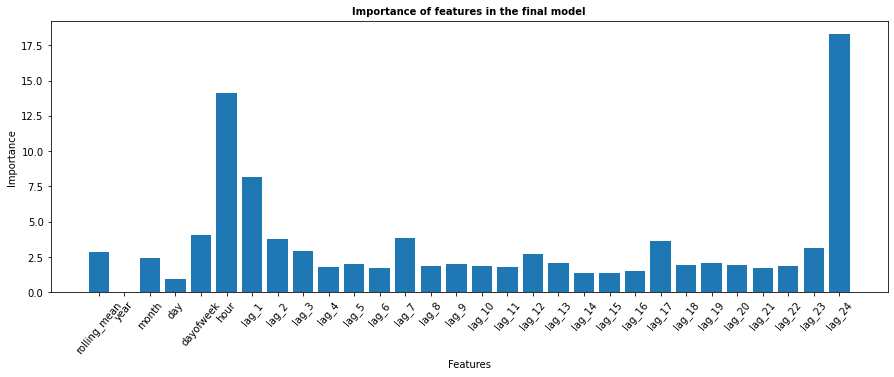

In [45]:
plt.figure(figsize=(15, 5))
plt.title("Importance of features in the final model", fontweight='bold', size='medium')

plt.ylabel("Importance")
plt.xlabel("Features")
plt.xticks(range(len(model_cat_boost.feature_importances_)), columns, rotation=50, size='medium')
plt.bar(
    range(len(model_cat_boost.feature_importances_)),
    model_cat_boost.feature_importances_)
plt.show()


We see that the factors that contributed the most:

- number of orders 24 hrs. ago,
- hour, time attribute,
- number of orders in the last hour.

The year was not important at all. Which is logical, since it is the same on all rows - 2018.

# Conclusion

<b>Brief project conclusions:</b>
- Data on cab orders from March to August 2018.
- Based on the graph, we can see that the number of orders is gradually increasing from March to August.
- The maximum number of orders per 1 hour was in August, there are even a few outliers.
- There is a certain trend: The number of orders on average is slowly increasing. 
- For example, in August the average number of orders per 1 hour is higher than in March. Also, the fluctuations in the data start to be stronger in August. Therefore, the standard deviation changes over time. 
- This suggests that our series is non-stationary.
- There is also seasonality, on a narrower segment we can see that it is cyclical by day.

Elementary models were first used for prediction. They showed the following results, but the RMSE of all of them is greater than 48 and does not meet the problem condition.

| N |       Model                | RMSE |  
|---|----------------------------|------------|
| 1 | Median |   87.15  |  
| 2 | Mean |   84.64 | 
| 3 | Previous |   58.85 | 
| 4 | Previous 24 |   57.18 |  

More complex models were used after. New attributes were added to the data before training: moving average of past data, lagged data, and temporal attributes. 
Results of model training:

| N |       Model                | RMSE |  
|---|----------------------------|------------|
| 1 | LinearRegression |   26.94 |   
| 2 | DecisionTreeRegressor |   30.65 |  
| 3 | RandomForestRegressor |   26.31 | 
| 4 | LGBMRegressor |   25.67 |
| 5 | <b>CatBoostRegressor</b> |   24.47 | 


 All models showed better quality in training than elementary ones - constants and shift to the previous value and to 24 hours back.
- The DecisionTreeRegressor model performed the worst, RMSE about 31.
- LinearRegression and RandomForestRegressor performed similarly with RMSE around 26.
- LGBMRegressor and CatBoostRegressor models showed themselves best of all (RMSE about 25 and 24), but CatBoostRegressor has a smaller RMSE.  That is why we stopped on it.

In testing the selected CatBoostRegressor model showed RMSE on the test 40.97, which is less than 48 and fits the task condition. Although the overtraining problem is definitely visible.

We can see that the factors that contributed the most when training the model:
- number of orders 24 hrs. ago,
- hour, time attribute,
- the number of orders for the last hour.